### 23.08.10 UPDATE
1. 데이터셋 내용 및 구성 변경
	- FPs feature transform 적용 해제 + 다른 3가지 feature 스케일링 후 합쳐서 데이터 셋 완성
	- 추후 FPs transform 적용해보기
2. Learning_Rate 1e-5로 조정
3. 레이어 계층 구조 변경
4. Loss function을 RMSELoss function으로 변경

In [1]:
import random
import os

import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import missingno

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42) # Seed 고정

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [4]:
train = train.fillna(train['AlogP'].median())

<Axes: >

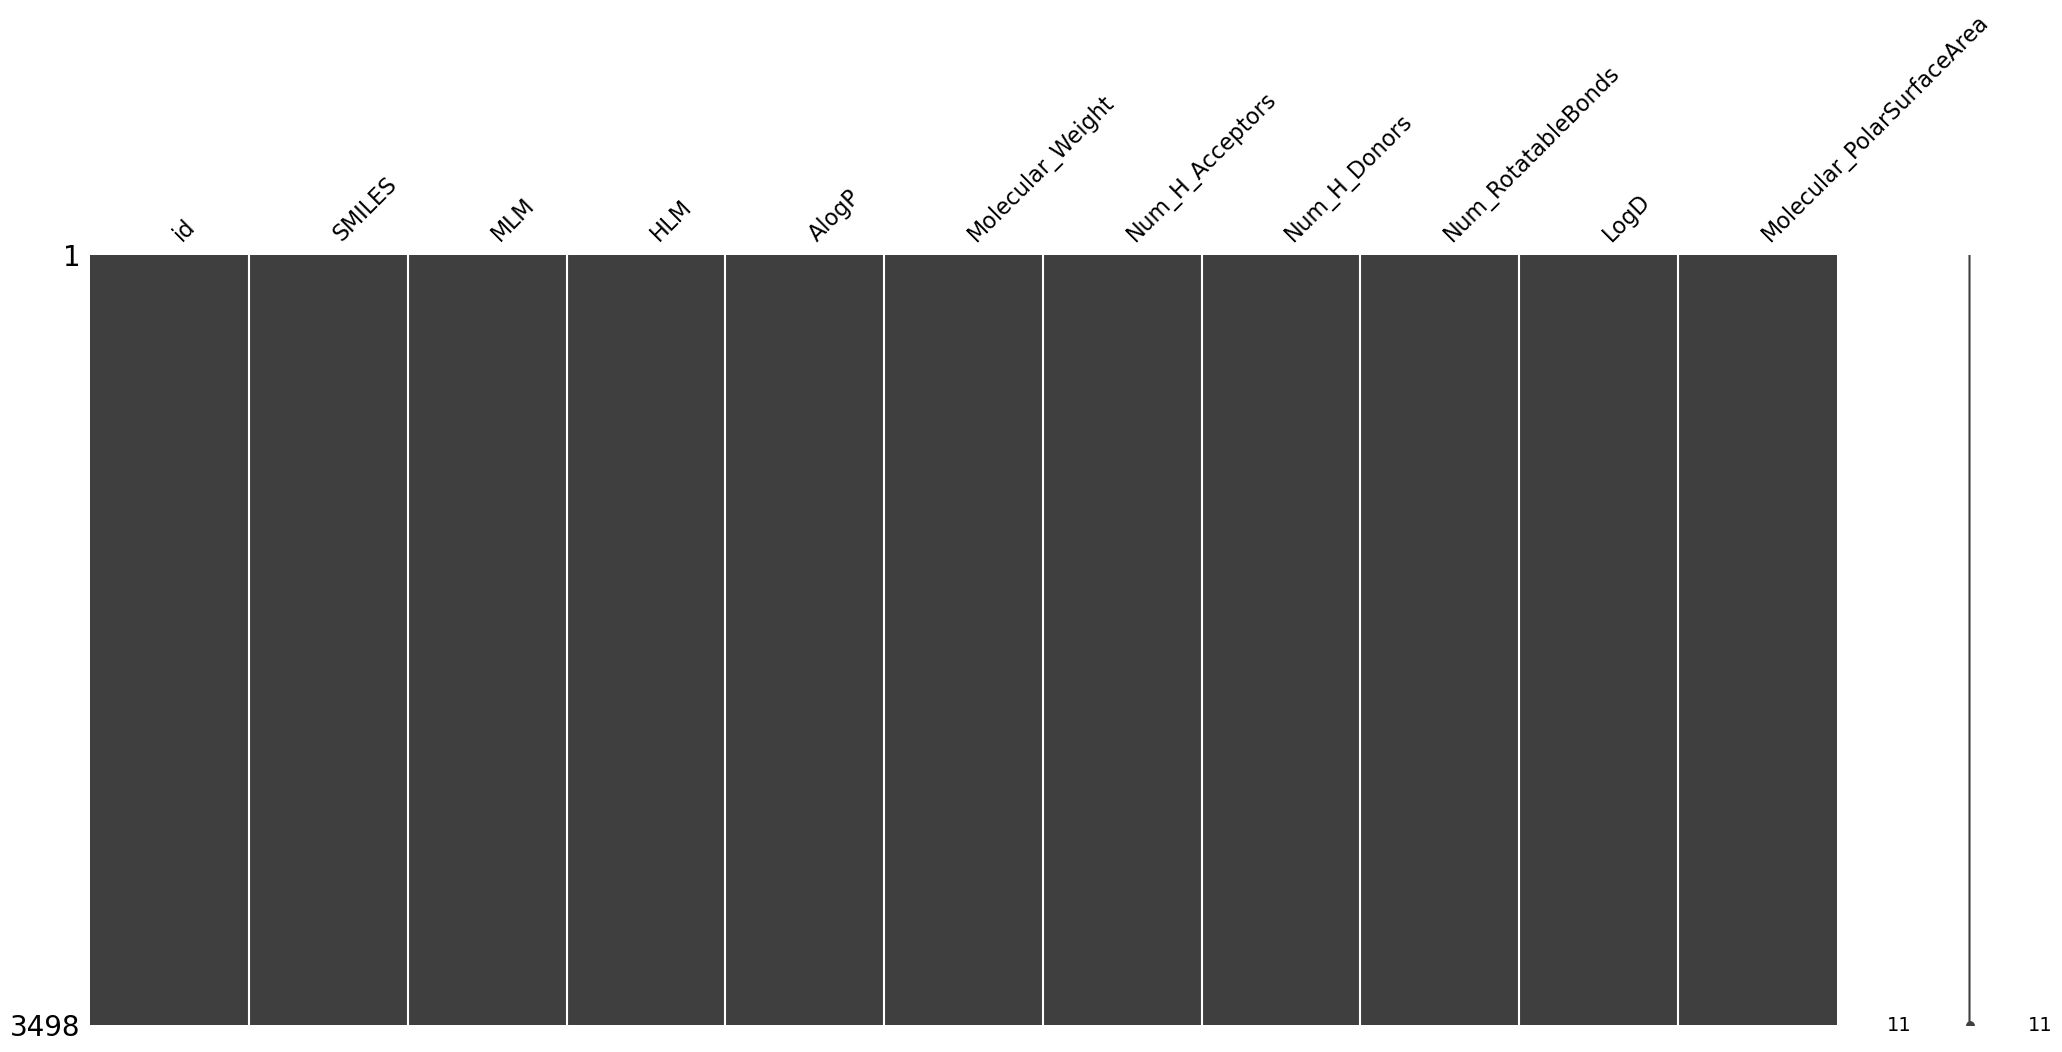

In [5]:
missingno.matrix(train)

In [6]:
!pip install rdkit-pypi

In [7]:
from rdkit import DataStructs
from rdkit.Chem import PandasTools,AllChem

PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

# FPs column 추가
train["FPs"] = train.Molecule.apply(mol2fp)
test["FPs"] = test.Molecule.apply(mol2fp)

In [8]:
# 사용할 column만 추출
train = train[['AlogP', 'Num_H_Donors', 'LogD', 'FPs', 'MLM', 'HLM']]
test = test[['AlogP', 'Num_H_Donors', 'LogD', 'FPs']]

In [9]:
train

,AlogP,Num_H_Donors,LogD,FPs,MLM,HLM
0,3.259,2,3.259,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",26.010,50.680
1,2.169,1,2.172,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",29.270,50.590
2,1.593,0,1.585,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.586,80.892
3,4.771,0,3.475,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.710,2.000
4,2.335,0,2.337,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",93.270,99.990
...,...,...,...,...,...,...
3493,3.409,1,3.409,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.556,3.079
3494,1.912,1,1.844,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35.560,47.630
3495,1.941,1,2.124,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",56.150,1.790
3496,0.989,1,0.989,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.030,2.770


In [10]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, df, target, transform, is_test=False):
        self.df = df
        self.target = target
        self.is_test = is_test

        self.feature_select = transform

        # 스케일링
        if not self.is_test:
            self.features = self.feature_select.transform(df.drop(['FPs','MLM', 'HLM'], axis=1))
        else:
            self.features = self.feature_select.transform(df.drop(['FPs'], axis=1))
            
        # 'FPs' 특성도 그대로 포함
        self.fps = np.stack(df['FPs'])

        # combined_features를 __init__ 메서드 내에서 계산
        self.combined_features = np.concatenate([self.features, self.fps], axis=1)

        if not self.is_test:
            self.labels = df[self.target].values
        else:
            self.labels = None

    def __getitem__(self, index):
        combined_feature = self.combined_features[index]

        if not self.is_test:
            label = self.labels[index]
            return torch.tensor(combined_feature).float(), torch.tensor(label).float().unsqueeze(dim=-1)
        else:
            return torch.tensor(combined_feature).float()

    def __len__(self):
        return len(self.df)


In [11]:
# 훈련 및 테스트 데이터를 불러오고 전처리합니다
train_transform = StandardScaler()
train_transform.fit(train.drop(['FPs','MLM', 'HLM'], axis=1))  # 훈련 데이터에 Scaler를 적합

test_transform = StandardScaler()
test_transform.fit(test.drop(['FPs'], axis=1))  # 훈련 데이터에 Scaler를 적합

train_MLM = CustomDataset(df=train, target='MLM', transform=train_transform, is_test=False)
train_HLM = CustomDataset(df=train, target='HLM', transform=train_transform, is_test=False)

test_MLM = CustomDataset(df=test, target='MLM', transform=test_transform, is_test=True)
test_HLM = CustomDataset(df=test, target='HLM', transform=test_transform, is_test=True)

input_size = train_MLM.combined_features.shape[1]
print(input_size)


4099


In [12]:
test_MLM.features

array([[-0.01492887,  0.95297089,  0.08479639],
       [-1.23881931, -1.0972961 , -1.05913519],
       [ 0.95834977,  3.00323789,  1.00831189],
       ...,
       [-0.52031942, -0.07216261, -0.3856106 ],
       [-1.11678743,  0.95297089, -1.14953369],
       [ 0.06900525, -1.0972961 , -1.04741687]])

In [13]:
# Hyperparameter
CFG = {'BATCH_SIZE': 256,
       'EPOCHS': 1000,
       'INPUT_SIZE': input_size,
       'HIDDEN_SIZE': 1024,
       'OUTPUT_SIZE': 1,
       'DROPOUT_RATE': 0.8,
       'LEARNING_RATE': 1e-5}

In [14]:
# train,valid split
train_MLM_dataset, valid_MLM_dataset = train_test_split(train_MLM, test_size=0.2, random_state=42)
train_HLM_dataset, valid_HLM_dataset = train_test_split(train_HLM, test_size=0.2, random_state=42)

In [15]:
train_MLM_loader = DataLoader(dataset=train_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_MLM_loader = DataLoader(dataset=valid_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)


train_HLM_loader = DataLoader(dataset=train_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_HLM_loader = DataLoader(dataset=valid_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)

test_MLM_loader = DataLoader(dataset=test_MLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

test_HLM_loader = DataLoader(dataset=test_HLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

In [16]:
class Net(nn.Module):
    def __init__(self, input_size, out_size):
        super(Net, self).__init__()
        
        self.linear_layers = nn.Sequential (  
            nn.Linear(input_size, 21843, bias=True),
            nn.LeakyReLU(),
            nn.BatchNorm1d(21843),
            nn.Linear(21843, 512, bias=True),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, out_size, bias=True),
        )
     
    def forward(self, x):
        y = self.linear_layers(x)
        return y

In [17]:
model_MLM = Net(CFG['INPUT_SIZE'],CFG['OUTPUT_SIZE'])
model_HLM = Net(CFG['INPUT_SIZE'],CFG['OUTPUT_SIZE'])

In [18]:
import torch.nn as nn

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()  # 기존의 MSELoss 함수 사용
        
    def forward(self, output, target):
        mse_loss = self.mse(output, target)  # 기존의 MSELoss를 계산
        rmse_loss = torch.sqrt(mse_loss)  # MSE에 제곱근 씌워 RMSE 계산
        return rmse_loss

criterion = RMSELoss()
optimizer_MLM = torch.optim.Adam(model_MLM.parameters(), lr=CFG['LEARNING_RATE'])
optimizer_HLM = torch.optim.Adam(model_HLM.parameters(), lr=CFG['LEARNING_RATE'])


In [19]:
def train(train_loader, valid_loader, model, criterion, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        if epoch % 100 == 0:
            valid_loss = 0
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = criterion(output, targets)
                    valid_loss += loss.item()
                    
            print(f'Epoch: {epoch}/{epochs}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {valid_loss/len(valid_HLM_loader)}')
            
            model.train()
    
    return model

In [111]:
print("Training Start: MLM")
model_MLM = train(train_MLM_loader, valid_MLM_loader, model_MLM, criterion, optimizer_MLM, epochs=CFG['EPOCHS'])

print("Training Start: HLM")
model_HLM = train(train_HLM_loader, valid_HLM_loader, model_HLM, criterion, optimizer_HLM, epochs=CFG['EPOCHS'])        

Training Start: MLM
Epoch: 0/1000, Train Loss: 51.017887115478516, Valid Loss: 51.80644226074219
Epoch: 100/1000, Train Loss: 41.54564042524858, Valid Loss: 50.33233769734701
Epoch: 200/1000, Train Loss: 38.99609999223189, Valid Loss: 50.27502314249674
Epoch: 300/1000, Train Loss: 37.205820603804156, Valid Loss: 50.51786677042643
Epoch: 400/1000, Train Loss: 35.989118576049805, Valid Loss: 51.06215031941732
Epoch: 500/1000, Train Loss: 35.21124874461781, Valid Loss: 51.56392161051432
Epoch: 600/1000, Train Loss: 34.55787121165883, Valid Loss: 51.32439168294271
Epoch: 700/1000, Train Loss: 33.71428593722257, Valid Loss: 50.317562103271484
Epoch: 800/1000, Train Loss: 32.63367548855868, Valid Loss: 49.35425567626953
Epoch: 900/1000, Train Loss: 31.3660401430997, Valid Loss: 48.37641270955404
Training Start: HLM
Epoch: 0/1000, Train Loss: 64.08195426247336, Valid Loss: 62.53731155395508
Epoch: 100/1000, Train Loss: 56.45296443592418, Valid Loss: 61.27613194783529
Epoch: 200/1000, Train Lo

### Save Model

In [119]:
torch.save(model_MLM.state_dict(), 'models/23.08.10_model_MLM.pth')  # 모델 객체의 state_dict 저장
torch.save(model_HLM.state_dict(), 'models/23.08.10_model_HLM.pth')

### Load Model

In [21]:
model_MLM.load_state_dict(torch.load('models/23.08.10_model_MLM.pth'))
model_HLM.load_state_dict(torch.load('models/23.08.10_model_HLM.pth'))

<All keys matched successfully>

In [121]:
def inference(test_loader, model):
    model.eval()
    preds = []
    
    with torch.no_grad():
        for inputs in test_loader:
            output = model(inputs)
            preds.extend(output.cpu().numpy().flatten().tolist())
    
    return preds

In [122]:
predictions_MLM = inference(test_MLM_loader, model_MLM)
predictions_HLM = inference(test_HLM_loader, model_HLM)

In [123]:
submission = pd.read_csv('./data/sample_submission.csv')

submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM
submission

,id,MLM,HLM
0,TEST_000,-12.575003,7.827060
1,TEST_001,31.561213,38.340233
2,TEST_002,4.566210,2.159594
3,TEST_003,0.073697,21.096611
4,TEST_004,-4.295326,21.358330
...,...,...,...
478,TEST_478,-12.380568,-18.808857
479,TEST_479,50.035934,41.234303
480,TEST_480,-8.212297,2.109220
481,TEST_481,29.442015,25.034269


In [124]:
submission.to_csv('23.08.10_submission.csv', index=False)